<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 LD-PLSM Modeling with MLR & Analysis of Variance (ANOVA)
</p>

In [1]:
# ================================== Libraries =======================================
import numpy as np                                           # For numerical operations
import pandas as pd                                          # For data manipulation and analysis
import matplotlib.pyplot as plt                              # For plotting and visualizations
import matplotlib.dates as mdates                            # For handling date formatting in plots
import seaborn as sns                                        # For enhanced data visualizations
import plotly.express as px                                  # For interactive data visualizations
from sklearn.linear_model import LinearRegression            # For linear regression modeling
from sklearn.metrics import mean_squared_error, r2_score     # For model evaluation metrics
from sklearn.mixture import GaussianMixture                  # For Gaussian mixture modeling
from sklearn.model_selection import KFold, train_test_split  # For splitting data and cross-validation
from scipy import stats                                      # For statistical functions
from scipy.optimize import curve_fit, minimize               # For curve fitting and optimization
from scipy.stats import kstest, norm, t, skewnorm, cauchy    # For statistical tests and distributions
from scipy.interpolate import interp1d                       # For 1D interpolation of data
import statsmodels.api as sm                                 # For advanced statistical modeling
import statsmodels.formula.api as smf                        # For formula-based statistical modeling

In [2]:
# Load the cleaned data by IF into 'df' and display it.
df = pd.read_csv('../../all_data_files/cleaned_dataset_per_device.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 749214 entries, 0 to 749213
Data columns (total 20 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   time         749214 non-null  object 
 1   device_id    749214 non-null  object 
 2   co2          749214 non-null  float64
 3   humidity     749214 non-null  float64
 4   pm25         749214 non-null  float64
 5   pressure     749214 non-null  float64
 6   temperature  749214 non-null  float64
 7   rssi         749214 non-null  float64
 8   snr          749214 non-null  float64
 9   SF           749214 non-null  int64  
 10  frequency    749214 non-null  float64
 11  f_count      749214 non-null  float64
 12  p_count      749214 non-null  float64
 13  toa          749214 non-null  float64
 14  distance     749214 non-null  int64  
 15  c_walls      749214 non-null  int64  
 16  w_walls      749214 non-null  int64  
 17  exp_pl       749214 non-null  float64
 18  n_power      749214 non-

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Data Preparation and Single Train-Test Split
</p>

In [3]:
# Extract all necessary columns
time_all = df['time'].values
d_all = df['distance'].values
frequency_all = df['frequency'].values 
c_walls_all = df['c_walls'].values
w_walls_all = df['w_walls'].values
PL_all = df['exp_pl'].values
co2_all = df['co2'].values
humidity_all = df['humidity'].values
pm25_all = df['pm25'].values
pressure_all = df['pressure'].values
temperature_all = df['temperature'].values
snr_all = df['snr'].values

# Combine all features into a single array
all_features = np.column_stack((
    d_all, frequency_all, c_walls_all, w_walls_all, co2_all, humidity_all,
    pm25_all, pressure_all, temperature_all, snr_all ))

# Perform a single train-test split (80-20 split), including time
X_train_all, X_test_all, PL_train_all, PL_test_all, time_train, time_test = train_test_split(
    all_features, PL_all, time_all, test_size=0.2, random_state=50 )

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Analyzing Temporal Distribution in Training and Testing Sets
</p>

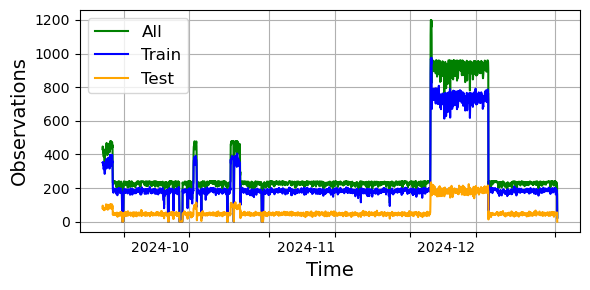

In [4]:
# Convert time arrays to pandas datetime Series
time_train = pd.to_datetime(time_train, format='ISO8601', errors='coerce')
time_test = pd.to_datetime(time_test, format='ISO8601', errors='coerce')

# Create DataFrames for training and testing times
train_time_df = pd.DataFrame({'time': time_train})
test_time_df = pd.DataFrame({'time': time_test})

# Remove timezone information if necessary
train_time_df['time'] = train_time_df['time'].dt.tz_localize(None)
test_time_df['time'] = test_time_df['time'].dt.tz_localize(None)

# Combine train and test times into one DataFrame with labels
train_time_df['Set'] = 'Train'
test_time_df['Set'] = 'Test'
all_time_df = pd.concat([train_time_df, test_time_df])

# Set 'time' as index
all_time_df.set_index('time', inplace=True)

# Resample counts per hour for 'All' data
all_counts = all_time_df.resample('h').size().rename('All')

# Resample counts per hour for 'Train' and 'Test' data
resampled_counts = all_time_df.groupby('Set').resample('h').size().unstack(level=0).fillna(0)

# Combine 'All' counts with 'Train' and 'Test' counts
resampled_counts = resampled_counts.join(all_counts)

# Plot time series line plot
fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(
    resampled_counts.index, resampled_counts['All'], label='All', linestyle='-', color='green'
)
ax.plot(
    resampled_counts.index, resampled_counts['Train'], label='Train', linestyle='-', color='blue'
)
ax.plot(
    resampled_counts.index, resampled_counts['Test'], label='Test', linestyle='-', color='orange'
)

# Format x-axis labels to avoid overlaps
ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('Observations', fontsize=14)

# Use AutoDateLocator and DateFormatter for better x-axis formatting
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Show every nth label on the x-axis
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

# Rotate date labels to prevent overlap
plt.setp(ax.get_xticklabels(), rotation=0, ha='right')

ax.legend(fontsize=12)
ax.grid(True)
plt.tight_layout()

# Save the figure to the specified directory with 1000 dpi
#plt.savefig('../all_data_files/Observations_Over_Time.png', dpi=1000)

# Show the plot
plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Defining LDPLM-MW-EP Model, Fitting, and Extracting Parameters
</p>

In [5]:
# Indices for features used in LDPLM-MW-EP
idx_ep = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Extract training and testing data for LDPLM-MW-EP
x_train_ep = X_train_all[:, idx_ep].T
x_test_ep = X_test_all[:, idx_ep].T
PL_train_ep = PL_train_all
PL_test_ep = PL_test_all

# Define the enhanced Log-Distance Path Loss Model with Environmental Parameters
def log_distance_path_loss_with_env_params(x, PL_d0, n, L_c, L_w, a_co2, a_hum, a_pm25, a_pres, a_temp, k_snr):
    d, frequency, c_walls, w_walls, co2, humidity, pm25, pressure, temperature, snr = x
    d0 = 1  # Reference distance in meters
    return (PL_d0 + 10 * n * np.log10(d / d0) + 20 * np.log10(frequency) + c_walls * L_c + w_walls * L_w +
            a_co2 * co2 + a_hum * humidity + a_pm25 * pm25 +
            a_pres * pressure + a_temp * temperature + snr * k_snr)

# Initial guesses for PL_d0, n, L_c, L_w, environmental factors, and SNR coefficient
initial_guesses_ep = [30, 2, 5, 3, 0.01, 0.01, 0.01, 0.01, 0.01, 1]  # Can be adjusted

# Perform curve fitting for LDPLM-MW-EP
popt_ep, pcov_ep = curve_fit(
    log_distance_path_loss_with_env_params,
    x_train_ep,
    PL_train_ep,
    p0=initial_guesses_ep,
    maxfev=100000
)

# Extract the fitted parameters for LDPLM-MW-EP
PL_d0_ep, n_ep, L_c_ep, L_w_ep, a_co2_ep, a_hum_ep, a_pm25_ep, a_pres_ep, a_temp_ep, k_snr_ep = popt_ep

# Predict path loss for the test set
PL_pred_ep = log_distance_path_loss_with_env_params(
    x_test_ep, PL_d0_ep, n_ep, L_c_ep, L_w_ep, a_co2_ep, a_hum_ep, a_pm25_ep, a_pres_ep, a_temp_ep, k_snr_ep
)

# Calculate the shadowing component for the training set
PL_train_pred_ep = log_distance_path_loss_with_env_params(
    x_train_ep, PL_d0_ep, n_ep, L_c_ep, L_w_ep, a_co2_ep, a_hum_ep, a_pm25_ep, a_pres_ep, a_temp_ep, k_snr_ep
)
shadowing_train_ep = PL_train_ep - PL_train_pred_ep
sigma_ep = np.std(shadowing_train_ep)

# Calculate RMSE and R-squared for LDPLM-MW-EP on Test Set
rmse_ep = np.sqrt(mean_squared_error(PL_test_ep, PL_pred_ep))
r_squared_ep = r2_score(PL_test_ep, PL_pred_ep)

# Calculate RMSE and R-squared for LDPLM-MW-EP on Training Set
rmse_train_ep = np.sqrt(mean_squared_error(PL_train_ep, PL_train_pred_ep))
r_squared_train_ep = r2_score(PL_train_ep, PL_train_pred_ep)

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Parameters and Metrics for the the Model
</p>

In [6]:
# Parameters for LDPLM-MW-EP
params_ep = {
    'PL(d0) [dB]': PL_d0_ep,
    'Path loss exponent (n)': n_ep,
    'Brick Wall Loss (L_c) [dB]': L_c_ep,
    'Wood Wall Loss (L_w) [dB]': L_w_ep,
    'CO2 coefficient (a_co2) [dB/unit]': a_co2_ep,
    'Humidity coefficient (a_hum) [dB/unit]': a_hum_ep,
    'PM2.5 coefficient (a_pm25) [dB/unit]': a_pm25_ep,
    'Pressure coefficient (a_pres) [dB/unit]': a_pres_ep,
    'Temperature coefficient (a_temp) [dB/unit]': a_temp_ep,
    'SNR scaling factor (k_snr)': k_snr_ep
}

# Define the list of parameters
parameter_list = list(params_ep.keys())

# Create the LDPLM-MW-EP column
ldplm_ep_values = list(params_ep.values())

# Construct the DataFrame
params_df = pd.DataFrame({
    'Parameter': parameter_list,
    'LDPLM-MW-EP': ldplm_ep_values
})

print("\n=== Table of LDPLM-MW-EP Parameters ===\n")
display(params_df)

# Metrics for LDPLM-MW-EP
metrics = [
    'RMSE (Train) [dB]', 
    'RMSE (Test) [dB]', 
    'R-squared (Train)', 
    'R-squared (Test)', 
    'Shadowing σ (dB)'
]
metrics_values = {
    'LDPLM-MW-EP': [rmse_train_ep, rmse_ep, r_squared_train_ep, r_squared_ep, sigma_ep]
}

metrics_df = pd.DataFrame(metrics_values, index=metrics)

print("\n=== Performance Metrics for LDPLM-MW-EP ===\n")
display(metrics_df)


=== Table of LDPLM-MW-EP Parameters ===



,Parameter,LDPLM-MW-EP
0,PL(d0) [dB],-8.061482
1,Path loss exponent (n),4.073516
2,Brick Wall Loss (L_c) [dB],7.049695
3,Wood Wall Loss (L_w) [dB],1.946122
4,CO2 coefficient (a_co2) [dB/unit],-0.000618
5,Humidity coefficient (a_hum) [dB/unit],-0.149558
6,PM2.5 coefficient (a_pm25) [dB/unit],-0.061496
7,Pressure coefficient (a_pres) [dB/unit],0.008420
8,Temperature coefficient (a_temp) [dB/unit],0.025505
9,SNR scaling factor (k_snr),-1.925304



=== Performance Metrics for LDPLM-MW-EP ===



,LDPLM-MW-EP
RMSE (Train) [dB],7.866077
RMSE (Test) [dB],7.868468
R-squared (Train),0.825902
R-squared (Test),0.825866
Shadowing σ (dB),7.866077


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Plotting some assessement Metrics for the Model
</p>

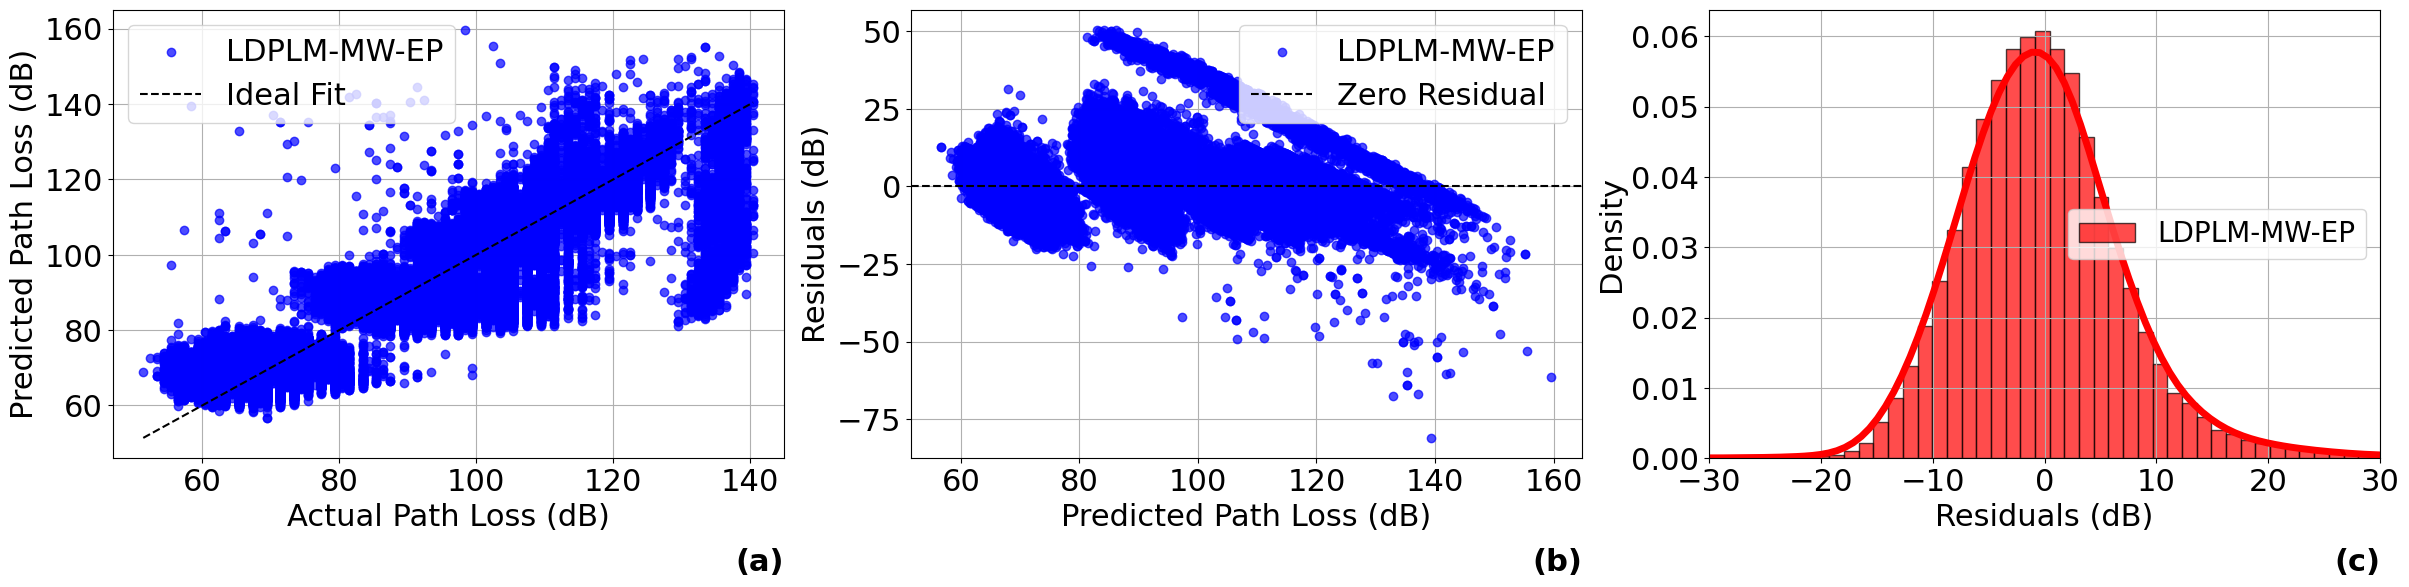


Residual Distribution Values:

LDPLM-MW-EP: Mean: -0.0358 dB, Skewness: 1.209


In [7]:
# -------------------------------
# Section 4: Plotting
# -------------------------------

# Step 15, 16 & 17: Plot Actual vs Predicted Path Loss, Residual Analysis, and Histogram as Subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))

# Step 15: Plot Actual vs Predicted Path Loss on ax1 for LDPLM-MW-EP
ax1.scatter(PL_test_ep, PL_pred_ep, alpha=0.7, label='LDPLM-MW-EP', color='blue', zorder=2)
# Ideal Fit Line in black, highest zorder to appear on top
ax1.plot(
    [PL_test_ep.min(), PL_test_ep.max()],
    [PL_test_ep.min(), PL_test_ep.max()],
    'k--', label='Ideal Fit', zorder=3
)
ax1.set_xlabel('Actual Path Loss (dB)', fontsize=22)
ax1.set_ylabel('Predicted Path Loss (dB)', fontsize=22)
# ax1.set_title('Actual vs Predicted Path Loss')
ax1.legend(fontsize=22, loc='upper left')
ax1.grid(True)
ax1.tick_params(axis='both', which='major', labelsize=22)
ax1.text(1, -0.2, '(a)', transform=ax1.transAxes, fontsize=22, fontweight='bold', va='top', ha='right')

# Step 16: Residual Analysis - Residuals vs Predicted Path Loss for LDPLM-MW-EP
residuals_ep = PL_test_ep - PL_pred_ep

# Step 16: Residual Analysis - Residuals vs Predicted Path Loss on ax2 for LDPLM-MW-EP
ax2.scatter(PL_pred_ep, residuals_ep, alpha=0.7, label='LDPLM-MW-EP', color='blue', zorder=2)
# Horizontal line at zero in black, highest zorder to appear on top
ax2.axhline(0, color='k', linestyle='--', label='Zero Residual', zorder=3)
ax2.set_xlabel('Predicted Path Loss (dB)', fontsize=22)
ax2.set_ylabel('Residuals (dB)', fontsize=22)
# ax2.set_title('Residuals vs Predicted Path Loss')
ax2.legend(fontsize=22, loc='upper right')
ax2.grid(True)
ax2.tick_params(axis='both', which='major', labelsize=22)
ax2.text(1, -0.2, '(b)', transform=ax2.transAxes, fontsize=22, fontweight='bold', va='top', ha='right')

# Step 17: Residual Analysis - Histogram of Residuals on ax3 for LDPLM-MW-EP
# Plot histogram for LDPLM-MW-EP with density normalization
ax3.hist(residuals_ep, bins=100, alpha=0.7, label='LDPLM-MW-EP', color='red', edgecolor='k', density=True)
# KDE plot using Seaborn 
sns.kdeplot(residuals_ep, color='red', bw_adjust=3, ax=ax3, linewidth=5)

ax3.set_xlabel('Residuals (dB)', fontsize=22)
ax3.set_ylabel('Density', fontsize=22)  # Changed from 'Frequency' to 'Density' due to normalization
# ax3.set_title('Histogram of Residuals')
ax3.set_xlim(-30, 30)  # Set x-axis limits
ax3.legend(fontsize=20, loc='center right')
ax3.grid(True)
ax3.tick_params(axis='both', which='major', labelsize=22)
ax3.text(1, -0.2, '(c)', transform=ax3.transAxes, fontsize=22, fontweight='bold', va='top', ha='right')

# Adjust layout to prevent overlapping
plt.tight_layout()
# Save the combined figure with a descriptive name
# plt.savefig('../all_data_files/All_Plots_as_Subplots_LDPLM-MW-EP.png', dpi=1000)
plt.show()

# Convert numpy arrays to pandas Series for residual distribution values
residuals_ep = pd.Series(residuals_ep)

# Residual Distribution Values for LDPLM-MW-EP
resid_mean_ep = round(residuals_ep.mean(), 4)
resid_skew_ep = round(residuals_ep.skew(), 4)

print(f'\nResidual Distribution Values:')
print(f'\nLDPLM-MW-EP: Mean: {resid_mean_ep} dB, Skewness: {resid_skew_ep}')

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Cross-Validation
</p>

In [8]:
# -------------------------------
# Section 5: 
# -------------------------------

print("\n=== Cross-Validation (5-Fold) for LDPLM-MW-EP ===\n")

X_all = all_features 
kf = KFold(n_splits=5, shuffle=True, random_state=50)

# Define idx_ep to include all relevant feature indices
idx_ep = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  

# Initialize lists to store metrics
rmse_list_ep_train = []
r_squared_list_ep_train = []
rmse_list_ep_test = []
r_squared_list_ep_test = []

fold_metrics = []  # To store metrics for each fold

for fold, (train_index, test_index) in enumerate(kf.split(df), 1):
    # Extract training and testing data for LDPLM-MW-EP
    x_train_cv_ep = X_all[train_index][:, idx_ep].T  # Transpose to match original shape
    x_test_cv_ep = X_all[test_index][:, idx_ep].T
    PL_train_cv_ep = PL_all[train_index]
    PL_test_cv_ep = PL_all[test_index]
    
    try:
        popt_cv_ep, _ = curve_fit(
            log_distance_path_loss_with_env_params,
            x_train_cv_ep,
            PL_train_cv_ep,
            p0=initial_guesses_ep,
            maxfev=100000
        )
        
        (PL_d0_cv_ep, n_cv_ep, L_c_cv_ep, L_w_cv_ep, a_co2_cv_ep, 
         a_hum_cv_ep, a_pm25_cv_ep, a_pres_cv_ep, a_temp_cv_ep, k_snr_cv_ep) = popt_cv_ep
        
        PL_pred_cv_ep = log_distance_path_loss_with_env_params(
            x_test_cv_ep, PL_d0_cv_ep, n_cv_ep, L_c_cv_ep, L_w_cv_ep,
            a_co2_cv_ep, a_hum_cv_ep, a_pm25_cv_ep, a_pres_cv_ep, a_temp_cv_ep, k_snr_cv_ep
        )
        
        # Calculate RMSE and R-squared on Test Set for LDPLM-MW-EP
        rmse_cv_ep_test = np.sqrt(mean_squared_error(PL_test_cv_ep, PL_pred_cv_ep))
        r2_cv_ep_test = r2_score(PL_test_cv_ep, PL_pred_cv_ep)
        
        # Calculate RMSE and R-squared on Training Set for LDPLM-MW-EP 
        PL_train_pred_cv_ep = log_distance_path_loss_with_env_params(
            x_train_cv_ep, PL_d0_cv_ep, n_cv_ep, L_c_cv_ep, L_w_cv_ep,
            a_co2_cv_ep, a_hum_cv_ep, a_pm25_cv_ep, a_pres_cv_ep, a_temp_cv_ep, k_snr_cv_ep
        )
        rmse_cv_ep_train = np.sqrt(mean_squared_error(PL_train_cv_ep, PL_train_pred_cv_ep))
        r2_cv_ep_train = r2_score(PL_train_cv_ep, PL_train_pred_cv_ep)
        
        rmse_list_ep_test.append(rmse_cv_ep_test)
        r_squared_list_ep_test.append(r2_cv_ep_test)
        rmse_list_ep_train.append(rmse_cv_ep_train)
        r_squared_list_ep_train.append(r2_cv_ep_train)
        
    except RuntimeError:
        print(f"Curve fitting failed for LDPLM-MW-EP Fold {fold}.")
        rmse_list_ep_test.append(np.nan)
        r_squared_list_ep_test.append(np.nan)
        rmse_list_ep_train.append(np.nan)
        r_squared_list_ep_train.append(np.nan)
    
    fold_metrics.append({
        'Fold': fold,
        'LDPLM-MW-EP RMSE Train (dB)': rmse_cv_ep_train,
        'LDPLM-MW-EP R² Train': r2_cv_ep_train,
        'LDPLM-MW-EP RMSE Test (dB)': rmse_cv_ep_test,
        'LDPLM-MW-EP R² Test': r2_cv_ep_test
    })

# Create Fold-wise Metrics Table
fold_df = pd.DataFrame(fold_metrics)
fold_df.set_index('Fold', inplace=True)
fold_df = fold_df.rename_axis(index='Fold')

# Reorganize columns for better comparison
fold_df = fold_df[[
    'LDPLM-MW-EP RMSE Train (dB)', 'LDPLM-MW-EP R² Train',
    'LDPLM-MW-EP RMSE Test (dB)', 'LDPLM-MW-EP R² Test'
]]

# Display Fold-wise Metrics Table
print("=== Fold-wise Metrics for LDPLM-MW-EP ===")
display(fold_df)

# Calculate and Prepare the Average and Standard Deviation of Metrics
avg_rmse_ep_train = np.nanmean(rmse_list_ep_train)
std_rmse_ep_train = np.nanstd(rmse_list_ep_train)

avg_r2_ep_train = np.nanmean(r_squared_list_ep_train)
std_r2_ep_train = np.nanstd(r_squared_list_ep_train)

avg_rmse_ep_test = np.nanmean(rmse_list_ep_test)
std_rmse_ep_test = np.nanstd(rmse_list_ep_test)

avg_r2_ep_test = np.nanmean(r_squared_list_ep_test)
std_r2_ep_test = np.nanstd(r_squared_list_ep_test)

# Create Average Metrics Table
average_metrics = {
    'LDPLM-MW-EP': {
        'RMSE Train (dB)': f"{avg_rmse_ep_train:.2f} ± {std_rmse_ep_train:.2f}",
        'RMSE Test (dB)': f"{avg_rmse_ep_test:.2f} ± {std_rmse_ep_test:.2f}",
        'R² Train': f"{avg_r2_ep_train:.4f} ± {std_r2_ep_train:.4f}",
        'R² Test': f"{avg_r2_ep_test:.4f} ± {std_r2_ep_test:.4f}"
    }
}

# Convert the average_metrics dictionary to a DataFrame
average_df = pd.DataFrame(average_metrics)

# Display Average Metrics Table
print("\n=== Average Metrics Across Folds for LDPLM-MW-EP ===")
display(average_df)


=== Cross-Validation (5-Fold) for LDPLM-MW-EP ===

=== Fold-wise Metrics for LDPLM-MW-EP ===


,LDPLM-MW-EP RMSE Train (dB),LDPLM-MW-EP R² Train,LDPLM-MW-EP RMSE Test (dB),LDPLM-MW-EP R² Test
Fold,,,,
1,7.866077,0.825902,7.868468,0.825866
2,7.873137,0.825726,7.840161,0.826574
3,7.871247,0.825618,7.847688,0.827005
4,7.855467,0.826420,7.910706,0.823794
5,7.866281,0.825833,7.869508,0.826060



=== Average Metrics Across Folds for LDPLM-MW-EP ===


,LDPLM-MW-EP
RMSE Train (dB),7.87 ± 0.01
RMSE Test (dB),7.87 ± 0.02
R² Train,0.8259 ± 0.0003
R² Test,0.8259 ± 0.0011


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Analysyis of Variance (ANOVA) and Diagnostic Plots for the LDPLM-MW-EP Model
</p>

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PL   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                 2.905e+05
Date:                Thu, 02 Jan 2025   Prob (F-statistic):               0.00
Time:                        00:18:05   Log-Likelihood:            -2.0813e+06
No. Observations:              599371   AIC:                         4.163e+06
Df Residuals:                  599360   BIC:                         4.163e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1.347e+04    129.539    103.984      0.000    1.32e+04    1.37e+04
log_dist_factor     4.0719      0.009    465.465      0.000       4.055       4.089
log_freq_factor  -228.3353      2.204   -103.593      0.000    -232.655    -224.015
c_walls             7.0371      0.018    388.759      0.000       7.002       7.073
w_walls             1.9472      0.014    140.837      0.000       1.920       1.974
co2                -0.0006   7.96e-05     -7.290      0.000      -0.001      -0.000
humidity           -0.1500      0.002    -66.621      0.000      -0.154      -0.146
pm25               -0.0620      0.005    -12.861      0.000      -0.071      -0.053
pressure            0.0081      0.001      7.712      0.000       0.006       0.010
temperature         0.0266      0.005      5.647      0.000       0.017       0.036
snr                -1.9552      0.003   -628.878      0.000      -1.961      -1.949
==============================================================================
Omnibus:                   162097.015   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           952061.104
Skew:                           1.175   Prob(JB):                         0.00
Kurtosis:                       8.710   Cond. No.                     8.44e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.44e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""


Diagnostics Table:


,Distribution,Log-Likelihood,AIC,BIC,KS Test Statistic,KS Test p-value
0,Normal,-2081344.27,4162692.53,4162715.14,0.0624,0.0
1,Skew-Normal,-2055696.02,4111398.04,4111431.95,0.0452,0.0
2,Gaussian Mixture Model,-2030204.72,4060415.44,4060449.35,0.0103,0.0
3,Cauchy,-2107831.13,4215666.27,4215688.87,0.0819,0.0
4,t-Distribution,-2036146.17,4072298.34,4072332.25,0.0253,0.0



Best Fit (Based on AIC): Gaussian Mixture Model



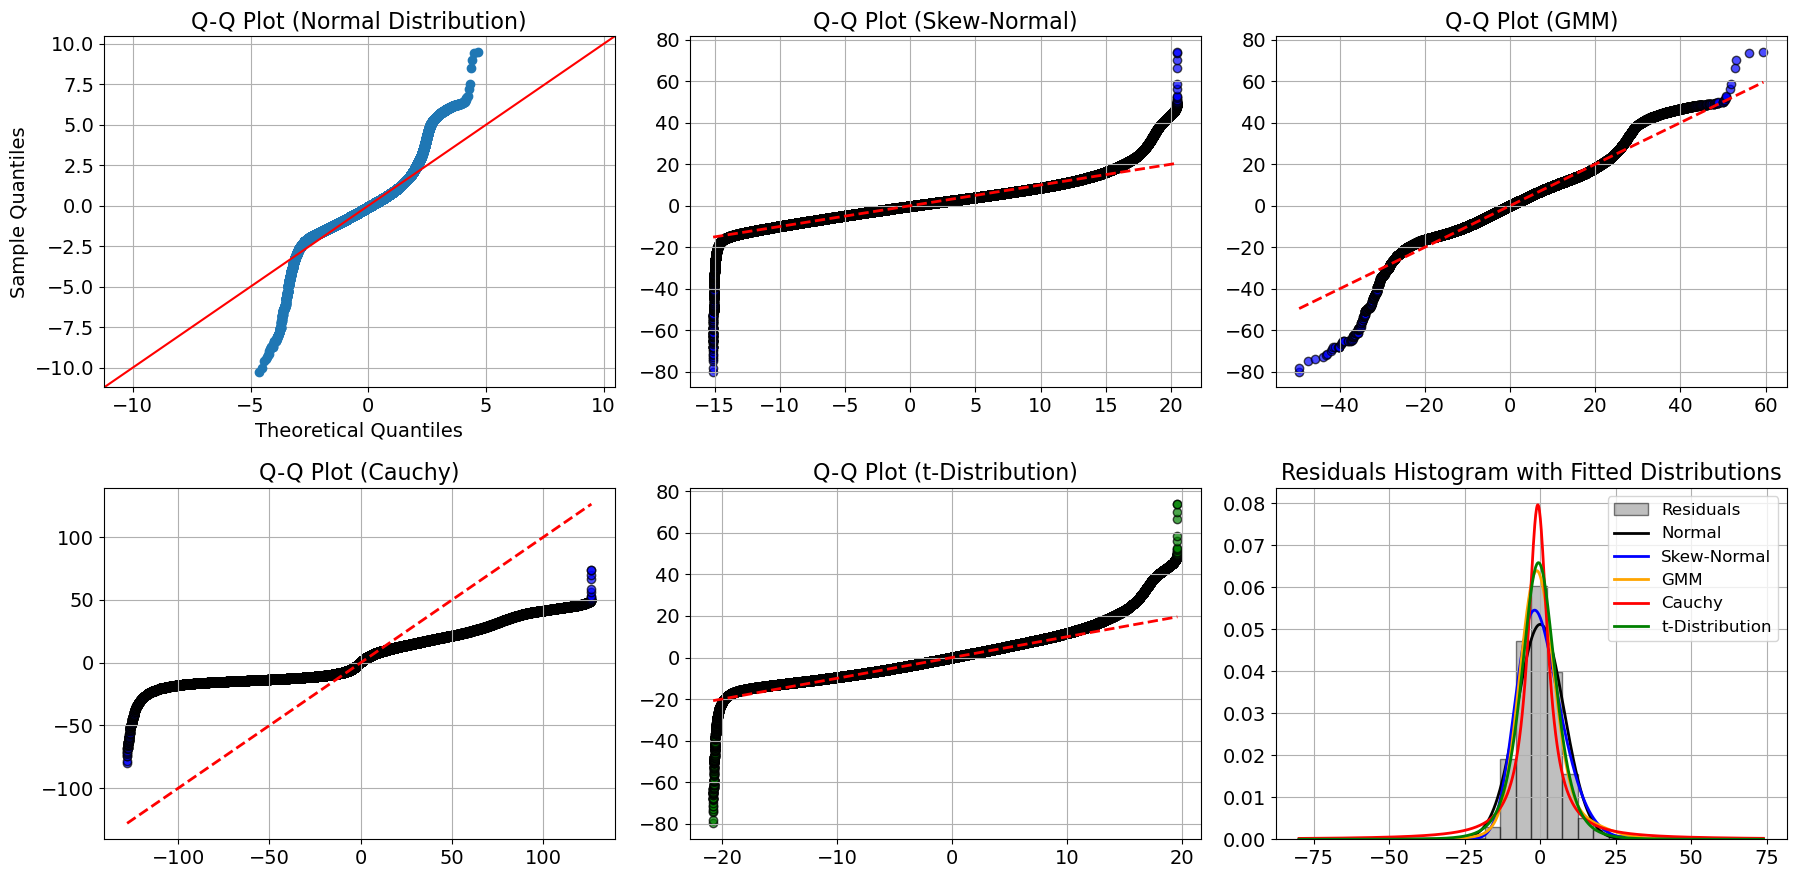

In [9]:
# Construct the DataFrame with your data
df_train = pd.DataFrame({
    'distance': X_train_all[:, 0],
    'frequency': X_train_all[:, 1],
    'c_walls': X_train_all[:, 2],
    'w_walls': X_train_all[:, 3],
    'co2': X_train_all[:, 4],
    'humidity': X_train_all[:, 5],
    'pm25': X_train_all[:, 6],
    'pressure': X_train_all[:, 7],
    'temperature': X_train_all[:, 8],
    'snr': X_train_all[:, 9],
    'PL': PL_train_all
})

# Transform distance and frequency
df_train['log_dist_factor'] = 10 * np.log10(df_train['distance'] / 1.0)
df_train['log_freq_factor'] = 20 * np.log10(df_train['frequency'])

# Fit OLS model with transformed predictors
formula = ('PL ~ log_dist_factor + log_freq_factor + c_walls + w_walls + co2 + '
           'humidity + pm25 + pressure + temperature + snr')
model = smf.ols(formula=formula, data=df_train).fit()

# Extract residuals from your model
residuals = model.resid

# Display model summary for context
display(model.summary())

# === Fit Distributions ===
# 1. Normal Distribution
normal_params = norm.fit(residuals)
loc_norm, scale_norm = normal_params
normal_dist = norm(loc=loc_norm, scale=scale_norm)

# 2. Skew-Normal Distribution
skew_params = stats.skewnorm.fit(residuals)
shape_sn, loc_sn, scale_sn = skew_params
skew_dist = stats.skewnorm(shape_sn, loc=loc_sn, scale=scale_sn)

# 3. Gaussian Mixture Model
residuals_array = residuals.values.reshape(-1, 1)
gmm = GaussianMixture(n_components=2, random_state=42).fit(residuals_array)
gmm_sample = gmm.sample(len(residuals))[0].flatten()

# 4. Cauchy Distribution
cauchy_params = stats.cauchy.fit(residuals)
cauchy_dist = stats.cauchy(*cauchy_params)

# 5. t-Distribution
t_params = stats.t.fit(residuals)
df_t, loc_t, scale_t = t_params
t_dist = stats.t(df=df_t, loc=loc_t, scale=scale_t)

# === Compute Log-Likelihood, AIC, BIC, and KS Test ===
def compute_aic_bic(log_likelihood, num_params, num_samples):
    """Compute AIC and BIC values."""
    aic = 2 * num_params - 2 * log_likelihood
    bic = num_params * np.log(num_samples) - 2 * log_likelihood
    return aic, bic

# Normal Distribution
loglik_norm = np.sum(np.log(normal_dist.pdf(residuals)))
aic_norm, bic_norm = compute_aic_bic(loglik_norm, 2, len(residuals))  # 2 params: loc, scale
ks_norm = kstest(residuals, normal_dist.cdf)

# Skew-Normal Distribution
loglik_sn = np.sum(np.log(skew_dist.pdf(residuals)))
aic_sn, bic_sn = compute_aic_bic(loglik_sn, 3, len(residuals))  # 3 params: shape, loc, scale
ks_sn = kstest(residuals, skew_dist.cdf)

# Gaussian Mixture Model
loglik_gmm = gmm.score(residuals_array) * len(residuals)  # score returns average log-likelihood
aic_gmm, bic_gmm = compute_aic_bic(loglik_gmm, 2 * gmm.n_components - 1, len(residuals))  # 2 components

# Define GMM CDF
def gmm_cdf(x, gmm):
    """
    Compute the CDF of a Gaussian Mixture Model at points x.

    Parameters:
    - x: array-like, points at which to evaluate the CDF.
    - gmm: fitted GaussianMixture object.

    Returns:
    - CDF values at x.
    """
    cdf = np.zeros_like(x, dtype=float)
    for weight, mean, cov in zip(gmm.weights_, gmm.means_.flatten(), gmm.covariances_.flatten()):
        std = np.sqrt(cov)
        cdf += weight * norm.cdf(x, loc=mean, scale=std)
    return cdf

# Compute KS Test for GMM using the defined CDF
ks_gmm = kstest(residuals, lambda x: gmm_cdf(x, gmm))

# Cauchy Distribution
loglik_cauchy = np.sum(np.log(cauchy_dist.pdf(residuals)))
aic_cauchy, bic_cauchy = compute_aic_bic(loglik_cauchy, 2, len(residuals))  # 2 params: loc, scale
ks_cauchy = kstest(residuals, cauchy_dist.cdf)

# t-Distribution
loglik_t = np.sum(np.log(t_dist.pdf(residuals)))
aic_t, bic_t = compute_aic_bic(loglik_t, 3, len(residuals))  # 3 params: df, loc, scale
ks_t = kstest(residuals, t_dist.cdf)

# === Compile Diagnostics into a DataFrame ===
diagnostics = pd.DataFrame({
    'Distribution': ['Normal', 'Skew-Normal', 'Gaussian Mixture Model', 'Cauchy', 't-Distribution'],
    'Log-Likelihood': [loglik_norm, loglik_sn, loglik_gmm, loglik_cauchy, loglik_t],
    'AIC': [aic_norm, aic_sn, aic_gmm, aic_cauchy, aic_t],
    'BIC': [bic_norm, bic_sn, bic_gmm, bic_cauchy, bic_t],
    'KS Test Statistic': [ks_norm.statistic, ks_sn.statistic, ks_gmm.statistic, ks_cauchy.statistic, ks_t.statistic],
    'KS Test p-value': [ks_norm.pvalue, ks_sn.pvalue, ks_gmm.pvalue, ks_cauchy.pvalue, ks_t.pvalue]
})

# Format the numerical columns for better readability
diagnostics['Log-Likelihood'] = diagnostics['Log-Likelihood'].round(2)
diagnostics['AIC'] = diagnostics['AIC'].round(2)
diagnostics['BIC'] = diagnostics['BIC'].round(2)
diagnostics['KS Test Statistic'] = diagnostics['KS Test Statistic'].round(4)
diagnostics['KS Test p-value'] = diagnostics['KS Test p-value'].round(4)

# Display the diagnostics table
print("\nDiagnostics Table:")
display(diagnostics)

# === Final Comparison ===
# Determine the best fit based on the lowest AIC
best_fit = diagnostics.loc[diagnostics['AIC'].idxmin()]
print(f"\nBest Fit (Based on AIC): {best_fit['Distribution']}\n")

# === Plot Diagnostic Subplots in a 3x2 Grid ===
# Increase font sizes for better readability
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'legend.fontsize': 12
})

fig, axes = plt.subplots(2, 3, figsize=(18, 9))  # 2 rows, 3 columns
axes = axes.flatten()  # Flatten to 1D array for easy indexing


# 1. Q-Q Plot (Normal)
sm.qqplot(residuals, line='45', fit=True, ax=axes[0])
axes[0].set_title('Q-Q Plot (Normal Distribution)')
axes[0].grid(True)  # Add grid

# 2. Q-Q Plot (Skew-Normal)
theoretical_skew = skew_dist.ppf(np.linspace(0.01, 0.99, len(residuals)))
empirical_skew = np.sort(residuals)
axes[1].scatter(theoretical_skew, empirical_skew, edgecolors='k', facecolor='blue', alpha=0.7)
axes[1].plot([min(theoretical_skew), max(theoretical_skew)], 
             [min(theoretical_skew), max(theoretical_skew)], 'r--', linewidth=2)
axes[1].set_title('Q-Q Plot (Skew-Normal)')
axes[1].grid(True)  # Add grid

# 3. Q-Q Plot (GMM)
gmm_sorted = np.sort(gmm_sample)
res_sorted = np.sort(residuals)
axes[2].scatter(gmm_sorted, res_sorted, edgecolors='k', facecolor='blue', alpha=0.7)
axes[2].plot([gmm_sorted.min(), gmm_sorted.max()], 
             [gmm_sorted.min(), gmm_sorted.max()], 'r--', linewidth=2)
axes[2].set_title('Q-Q Plot (GMM)')
axes[2].grid(True)  # Add grid

# 4. Q-Q Plot (Cauchy)
theoretical_cauchy = cauchy_dist.ppf(np.linspace(0.01, 0.99, len(residuals)))
axes[3].scatter(theoretical_cauchy, res_sorted, edgecolors='k', facecolor='blue', alpha=0.7)
axes[3].plot([min(theoretical_cauchy), max(theoretical_cauchy)], 
             [min(theoretical_cauchy), max(theoretical_cauchy)], 'r--', linewidth=2)
axes[3].set_title('Q-Q Plot (Cauchy)')
axes[3].grid(True)  # Add grid

# 5. Q-Q Plot (t-Distribution)
theoretical_t = t_dist.ppf(np.linspace(0.01, 0.99, len(residuals)))
axes[4].scatter(theoretical_t, res_sorted, edgecolors='k', facecolor='green', alpha=0.7)
axes[4].plot([min(theoretical_t), max(theoretical_t)], 
             [min(theoretical_t), max(theoretical_t)], 'r--', linewidth=2)
axes[4].set_title('Q-Q Plot (t-Distribution)')
axes[4].grid(True)  # Add grid

# 6. Residuals Histogram with Fitted Densities
axes[5].hist(residuals, bins=30, density=True, alpha=0.5, color='grey', edgecolor='black', label='Residuals')

# Plot fitted Normal Distribution
x_vals = np.linspace(residuals.min(), residuals.max(), 1000)
axes[5].plot(x_vals, normal_dist.pdf(x_vals), label='Normal', color='black', linewidth=2)

# Plot fitted Skew-Normal
axes[5].plot(x_vals, skew_dist.pdf(x_vals), label='Skew-Normal', color='blue', linewidth=2)

# Plot fitted GMM
axes[5].plot(x_vals, np.exp(gmm.score_samples(x_vals.reshape(-1, 1))), label='GMM', color='orange', linewidth=2)

# Plot fitted Cauchy
axes[5].plot(x_vals, cauchy_dist.pdf(x_vals), label='Cauchy', color='red', linewidth=2)

# Plot fitted t-Distribution
axes[5].plot(x_vals, t_dist.pdf(x_vals), label='t-Distribution', color='green', linewidth=2)

axes[5].set_title('Residuals Histogram with Fitted Distributions')
axes[5].legend(fontsize=12)
axes[5].grid(True)  # Add grid

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PL   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                 2.905e+05
Date:                Thu, 02 Jan 2025   Prob (F-statistic):               0.00
Time:                        00:19:10   Log-Likelihood:            -2.0813e+06
No. Observations:              599371   AIC:                         4.163e+06
Df Residuals:                  599360   BIC:                         4.163e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1.347e+04    129.539    103.984      0.000    1.32e+04    1.37e+04
log_dist_factor     4.0719      0.009    465.465      0.000       4.055       4.089
log_freq_factor  -228.3353      2.204   -103.593      0.000    -232.655    -224.015
c_walls             7.0371      0.018    388.759      0.000       7.002       7.073
w_walls             1.9472      0.014    140.837      0.000       1.920       1.974
co2                -0.0006   7.96e-05     -7.290      0.000      -0.001      -0.000
humidity           -0.1500      0.002    -66.621      0.000      -0.154      -0.146
pm25               -0.0620      0.005    -12.861      0.000      -0.071      -0.053
pressure            0.0081      0.001      7.712      0.000       0.006       0.010
temperature         0.0266      0.005      5.647      0.000       0.017       0.036
snr                -1.9552      0.003   -628.878      0.000      -1.961      -1.949
==============================================================================
Omnibus:                   162097.015   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           952061.104
Skew:                           1.175   Prob(JB):                         0.00
Kurtosis:                       8.710   Cond. No.                     8.44e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.44e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""


Diagnostics Table:


,Distribution,Log-Likelihood,AIC,BIC,KS Test Statistic,KS Test p-value
0,Normal,-2081344.27,4162692.53,4162715.14,0.0624,0.0
1,Skew-Normal,-2055696.02,4111398.04,4111431.95,0.0452,0.0
2,Gaussian Mixture Model,-2030204.72,4060415.44,4060449.35,0.0103,0.0
3,Cauchy,-2107831.13,4215666.27,4215688.87,0.0819,0.0
4,t-Distribution,-2036146.17,4072298.34,4072332.25,0.0253,0.0



Best Fit (Based on AIC): Gaussian Mixture Model



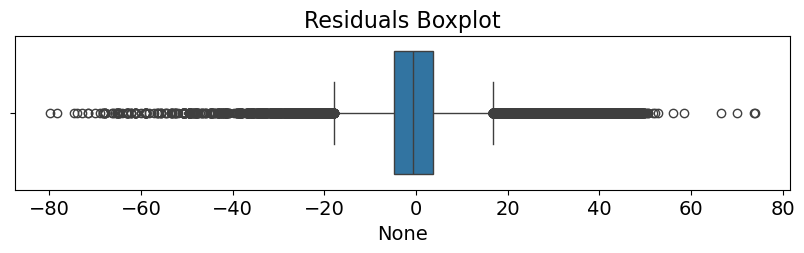

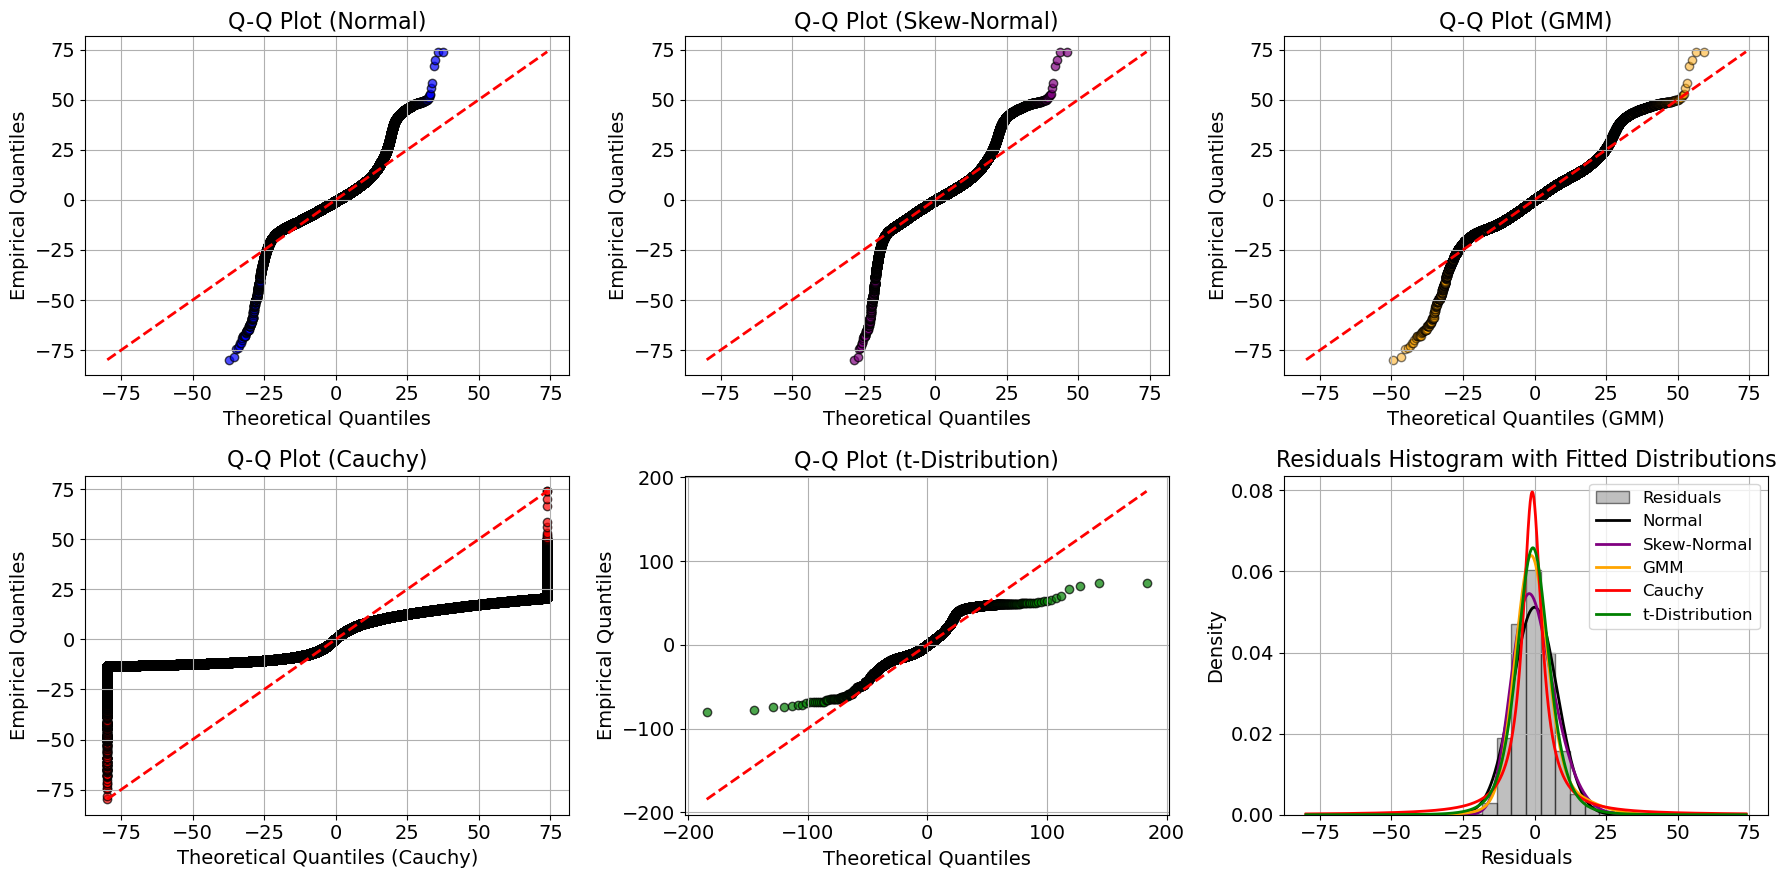

In [10]:
# Construct the DataFrame with your data
df_train = pd.DataFrame({
    'distance': X_train_all[:, 0],
    'frequency': X_train_all[:, 1],
    'c_walls': X_train_all[:, 2],
    'w_walls': X_train_all[:, 3],
    'co2': X_train_all[:, 4],
    'humidity': X_train_all[:, 5],
    'pm25': X_train_all[:, 6],
    'pressure': X_train_all[:, 7],
    'temperature': X_train_all[:, 8],
    'snr': X_train_all[:, 9],
    'PL': PL_train_all
})

# Transform distance and frequency
df_train['log_dist_factor'] = 10 * np.log10(df_train['distance'] / 1.0)
df_train['log_freq_factor'] = 20 * np.log10(df_train['frequency'])

# Fit OLS model with transformed predictors
formula = ('PL ~ log_dist_factor + log_freq_factor + c_walls + w_walls + co2 + '
           'humidity + pm25 + pressure + temperature + snr')
model = smf.ols(formula=formula, data=df_train).fit()

# Extract residuals from your model
residuals = model.resid
n = len(residuals)
sorted_residuals = np.sort(residuals)
probabilities = (np.arange(1, n + 1) - 0.5) / n  # Standard probability calculation

# Display model summary for context
display(model.summary())

# === Fit Distributions ===
# 1. Normal Distribution
normal_params = norm.fit(residuals)
loc_norm, scale_norm = normal_params
normal_dist = norm(loc=loc_norm, scale=scale_norm)

# 2. Skew-Normal Distribution
skew_params = skewnorm.fit(residuals)
shape_sn, loc_sn, scale_sn = skew_params
skew_dist = skewnorm(shape_sn, loc=loc_sn, scale=scale_sn)

# 3. Gaussian Mixture Model
residuals_array = residuals.values.reshape(-1, 1)
gmm = GaussianMixture(n_components=2, random_state=42).fit(residuals_array)

# 4. Cauchy Distribution
cauchy_params = cauchy.fit(residuals)
cauchy_dist = cauchy(*cauchy_params)

# 5. t-Distribution
t_params = t.fit(residuals)
df_t, loc_t, scale_t = t_params
t_dist = t(df=df_t, loc=loc_t, scale=scale_t)

# === Compute Log-Likelihood, AIC, BIC, and KS Test ===
def compute_aic_bic(log_likelihood, num_params, num_samples):
    """Compute AIC and BIC values."""
    aic = 2 * num_params - 2 * log_likelihood
    bic = num_params * np.log(num_samples) - 2 * log_likelihood
    return aic, bic

# Normal Distribution
loglik_norm = np.sum(np.log(normal_dist.pdf(residuals)))
aic_norm, bic_norm = compute_aic_bic(loglik_norm, 2, n)  # 2 params: loc, scale
ks_norm = kstest(residuals, normal_dist.cdf)

# Skew-Normal Distribution
loglik_sn = np.sum(np.log(skew_dist.pdf(residuals)))
aic_sn, bic_sn = compute_aic_bic(loglik_sn, 3, n)  # 3 params: shape, loc, scale
ks_sn = kstest(residuals, skew_dist.cdf)

# Gaussian Mixture Model
loglik_gmm = gmm.score(residuals_array) * n  # score returns average log-likelihood
aic_gmm, bic_gmm = compute_aic_bic(loglik_gmm, 2 * gmm.n_components - 1, n)  # 2 components

# Define GMM CDF
def gmm_cdf(x, gmm):
    """
    Compute the CDF of a Gaussian Mixture Model at points x.

    Parameters:
    - x: array-like, points at which to evaluate the CDF.
    - gmm: fitted GaussianMixture object.

    Returns:
    - CDF values at x.
    """
    cdf = np.zeros_like(x, dtype=float)
    for weight, mean, cov in zip(gmm.weights_, gmm.means_.flatten(), gmm.covariances_.flatten()):
        std = np.sqrt(cov)
        cdf += weight * norm.cdf(x, loc=mean, scale=std)
    return cdf

# Compute KS Test for GMM using the defined CDF
ks_gmm = kstest(residuals, lambda x: gmm_cdf(x, gmm))

# Cauchy Distribution
loglik_cauchy = np.sum(np.log(cauchy_dist.pdf(residuals)))
aic_cauchy, bic_cauchy = compute_aic_bic(loglik_cauchy, 2, n)  # 2 params: loc, scale
ks_cauchy = kstest(residuals, cauchy_dist.cdf)

# t-Distribution
loglik_t = np.sum(np.log(t_dist.pdf(residuals)))
aic_t, bic_t = compute_aic_bic(loglik_t, 3, n)  # 3 params: df, loc, scale
ks_t = kstest(residuals, t_dist.cdf)

# === Compile Diagnostics into a DataFrame ===
diagnostics = pd.DataFrame({
    'Distribution': ['Normal', 'Skew-Normal', 'Gaussian Mixture Model', 'Cauchy', 't-Distribution'],
    'Log-Likelihood': [loglik_norm, loglik_sn, loglik_gmm, loglik_cauchy, loglik_t],
    'AIC': [aic_norm, aic_sn, aic_gmm, aic_cauchy, aic_t],
    'BIC': [bic_norm, bic_sn, bic_gmm, bic_cauchy, bic_t],
    'KS Test Statistic': [ks_norm.statistic, ks_sn.statistic, ks_gmm.statistic, ks_cauchy.statistic, ks_t.statistic],
    'KS Test p-value': [ks_norm.pvalue, ks_sn.pvalue, ks_gmm.pvalue, ks_cauchy.pvalue, ks_t.pvalue]
})

# Format the numerical columns for better readability
diagnostics['Log-Likelihood'] = diagnostics['Log-Likelihood'].round(2)
diagnostics['AIC'] = diagnostics['AIC'].round(2)
diagnostics['BIC'] = diagnostics['BIC'].round(2)
diagnostics['KS Test Statistic'] = diagnostics['KS Test Statistic'].round(4)
diagnostics['KS Test p-value'] = diagnostics['KS Test p-value'].round(4)

# Display the diagnostics table
print("\nDiagnostics Table:")
display(diagnostics)

# === Final Comparison ===
# Determine the best fit based on the lowest AIC
best_fit = diagnostics.loc[diagnostics['AIC'].idxmin()]
print(f"\nBest Fit (Based on AIC): {best_fit['Distribution']}\n")

# === Inspect Residuals for Outliers ===
plt.figure(figsize=(10, 2))
sns.boxplot(x=residuals)
plt.title('Residuals Boxplot')
plt.show()

# === Plot Diagnostic Subplots in a 2x3 Grid ===
# Increase font sizes for better readability
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'legend.fontsize': 12
})

fig, axes = plt.subplots(2, 3, figsize=(18, 9))  # 2 rows, 3 columns
axes = axes.flatten()  # Flatten to 1D array for easy indexing

# Function to create manual Q-Q plots
def manual_qq_plot(distribution, dist_name, sorted_residuals, probabilities, ax, color='blue'):
    """
    Create a manual Q-Q plot.

    Parameters:
    - distribution: frozen scipy.stats distribution object.
    - dist_name: string, name of the distribution.
    - sorted_residuals: array-like, sorted residuals.
    - probabilities: array-like, cumulative probabilities.
    - ax: matplotlib axis object.
    - color: color for the scatter points.
    """
    theoretical_quantiles = distribution.ppf(probabilities)
    ax.scatter(theoretical_quantiles, sorted_residuals, edgecolors='k', facecolor=color, alpha=0.7)
    min_val = min(theoretical_quantiles.min(), sorted_residuals.min())
    max_val = max(theoretical_quantiles.max(), sorted_residuals.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
    ax.set_title(f'Q-Q Plot ({dist_name})')
    ax.set_xlabel('Theoretical Quantiles')
    ax.set_ylabel('Empirical Quantiles')
    ax.grid(True)

# 1. Q-Q Plot (Normal Distribution)
manual_qq_plot(normal_dist, 'Normal', sorted_residuals, probabilities, axes[0], color='blue')

# 2. Q-Q Plot (Skew-Normal Distribution)
manual_qq_plot(skew_dist, 'Skew-Normal', sorted_residuals, probabilities, axes[1], color='purple')

# 3. Q-Q Plot (Gaussian Mixture Model)
# Implement Custom PPF for GMM using Interpolation

# Create a Dense Grid for X-values
x_grid = np.linspace(residuals.min(), residuals.max(), 100000)
cdf_grid = gmm_cdf(x_grid, gmm)

# Ensure CDF is monotonically increasing for interpolation
unique_cdf, unique_indices = np.unique(cdf_grid, return_index=True)
unique_x = x_grid[unique_indices]

# Create the Inverse CDF (PPF) Function via Interpolation
ppf_func = interp1d(unique_cdf, unique_x, bounds_error=False, fill_value=(x_grid[0], x_grid[-1]))

# Compute Theoretical GMM Quantiles
theoretical_gmm_quantiles = ppf_func(probabilities)

# Plot GMM Q-Q Plot
axes[2].scatter(theoretical_gmm_quantiles, sorted_residuals, edgecolors='k', facecolor='orange', alpha=0.5)
min_val = min(theoretical_gmm_quantiles.min(), sorted_residuals.min())
max_val = max(theoretical_gmm_quantiles.max(), sorted_residuals.max())
axes[2].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[2].set_title('Q-Q Plot (GMM)')
axes[2].set_xlabel('Theoretical Quantiles (GMM)')
axes[2].set_ylabel('Empirical Quantiles')
axes[2].grid(True)

# 4. Q-Q Plot (Cauchy Distribution)
# Define a reasonable range based on residuals
lower_bound = residuals.min()
upper_bound = residuals.max()

# Compute theoretical quantiles
theoretical_quantiles = cauchy_dist.ppf(probabilities)
# Clip the theoretical quantiles to the residuals' range to prevent extreme values from distorting the plot
theoretical_quantiles_clipped = np.clip(theoretical_quantiles, lower_bound, upper_bound)

# Plot Cauchy Q-Q Plot
axes[3].scatter(theoretical_quantiles_clipped, sorted_residuals, edgecolors='k', facecolor='red', alpha=0.7)
axes[3].plot([lower_bound, upper_bound], [lower_bound, upper_bound], 'r--', linewidth=2)
axes[3].set_title('Q-Q Plot (Cauchy)')
axes[3].set_xlabel('Theoretical Quantiles (Cauchy)')
axes[3].set_ylabel('Empirical Quantiles')
axes[3].grid(True)

# 5. Q-Q Plot (t-Distribution)
manual_qq_plot(t_dist, 't-Distribution', sorted_residuals, probabilities, axes[4], color='green')

# 6. Residuals Histogram with Fitted Densities
axes[5].hist(residuals, bins=30, density=True, alpha=0.5, color='grey', edgecolor='black', label='Residuals')

# Plot fitted Normal Distribution
x_vals = np.linspace(residuals.min(), residuals.max(), 1000)
axes[5].plot(x_vals, normal_dist.pdf(x_vals), label='Normal', color='black', linewidth=2)

# Plot fitted Skew-Normal
axes[5].plot(x_vals, skew_dist.pdf(x_vals), label='Skew-Normal', color='purple', linewidth=2)

# Plot fitted GMM
# Calculate the GMM density
gmm_density = np.exp(gmm.score_samples(x_vals.reshape(-1, 1)))
axes[5].plot(x_vals, gmm_density, label='GMM', color='orange', linewidth=2)

# Plot fitted Cauchy
axes[5].plot(x_vals, cauchy_dist.pdf(x_vals), label='Cauchy', color='red', linewidth=2)

# Plot fitted t-Distribution
axes[5].plot(x_vals, t_dist.pdf(x_vals), label='t-Distribution', color='green', linewidth=2)

axes[5].set_title('Residuals Histogram with Fitted Distributions')
axes[5].set_xlabel('Residuals')
axes[5].set_ylabel('Density')
axes[5].legend(fontsize=12)
axes[5].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()